# Hawkes Process
## Self-Exciting Behavior and Detecting the End of Price Trends | Algorithmic Trading Strategy
Following the instruction on the youtube video to see if can be used in future strategies.

In [74]:
import pandas as pd
import talib as ta
import numpy as np
import matplotlib.pyplot as plt
import glob

In [86]:
# use this if the data is all in one file
# data = pd.read_csv("/Users/gabrielefabietti/projects/fetch_data/data/ETHUSDT_perp_1h_2021-06-01_to_2022-01-01.csv")

# use this if the data is in multiple files
directory_path = "/Users/gabrielefabietti/projects/fetch_data/data/"

# List all CSV files in the directory
csv_files = glob.glob(directory_path + "SOLUSDT_perp_1h_*.csv")

# Read each file and store the DataFrames in a list
data_frames = [pd.read_csv(file) for file in csv_files]

# Concatenate all the DataFrames
data = pd.concat(data_frames)

# Remove duplicate timestamps
data.drop_duplicates(subset='timestamp', inplace=True)

# Sort by timestamp
data = data.sort_values(by='timestamp').reset_index(drop=True)

# Convert 'timestamp' to datetime and set as index
data['timestamp'] = data['timestamp'].astype('datetime64[s]')
data = data.set_index('timestamp')

In [87]:
print(data)
print(data.info())

                        open     high      low    close    volume  \
timestamp                                                           
2021-12-31 23:00:00  170.400  171.225  169.765  170.090    4507.3   
2022-01-01 00:00:00  170.090  172.600  170.080  172.485    6704.9   
2022-01-01 01:00:00  172.485  174.390  171.785  172.815   14529.9   
2022-01-01 02:00:00  172.815  173.250  172.620  172.770    2421.1   
2022-01-01 03:00:00  172.770  173.085  172.570  172.945    2476.8   
...                      ...      ...      ...      ...       ...   
2024-05-14 18:00:00  142.810  143.980  142.530  143.830  216596.3   
2024-05-14 19:00:00  143.830  144.640  143.580  143.750  139128.1   
2024-05-14 20:00:00  143.750  143.860  142.780  142.950  152838.9   
2024-05-14 21:00:00  142.950  143.540  142.310  143.250  108136.6   
2024-05-14 22:00:00  143.250  143.250  142.160  142.980   89483.0   

                         turnover  
timestamp                          
2021-12-31 23:00:00  7.689894e

In [88]:
norm_lookback = 336
data['atr'] = ta.ATR(np.log(data['high']), np.log(data['low']), np.log(data['close']), norm_lookback)
data['norm_range'] = (np.log(data['high']) - np.log(data['low'])) / data['atr']

In [89]:
# Define the function to plot two axes
def plot_two_axes(series1, series2, label1='Series 1', label2='Series 2'):
    fig, ax1 = plt.subplots()

    color_grey = 'lightgrey'
    ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
    ax2.set_ylabel(label2, color=color_grey)  # We already handled the x-label with ax1
    ax2.plot(series2.index, series2, color=color_grey)
    ax2.tick_params(axis='y', labelcolor=color_grey)

    color_blue = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel(label1, color=color_blue)
    ax1.plot(series1.index, series1, color=color_blue)
    ax1.tick_params(axis='y', labelcolor=color_blue)

    # Draw the blue line (Log Close) on top by re-plotting it
    ax1.plot(series1.index, series1, color=color_blue, zorder=10)

    fig.tight_layout()  # Otherwise, the right y-label is slightly clipped

    plt.show()

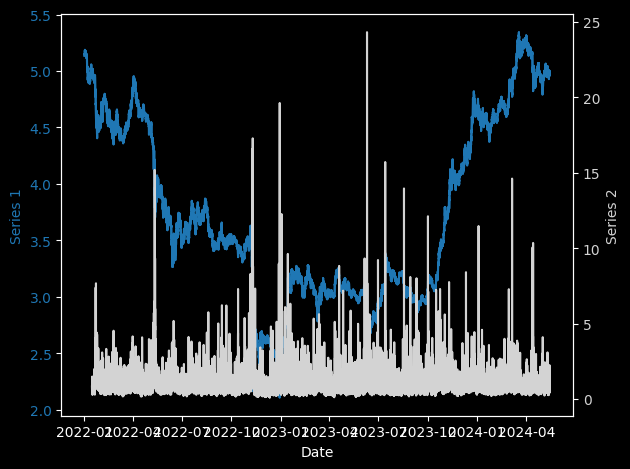

In [90]:
plot_two_axes(np.log(data['close']), data['norm_range'])

In [91]:
def hawkes_process(data: pd.Series, kappa: float):
    assert(kappa > 0.0)
    alpha = np.exp(-kappa)
    arr = data.to_numpy()
    output = np.zeros(len(data))
    output[:] = np.nan
    for i in range(1, len(data)):
        if np.isnan(output[i - 1]):
            output[i] = arr[i]
        else:
            output[i] = output[i - 1] * alpha + arr[i]
    return pd.Series(output, index=data.index) * kappa

In [92]:
def vol_signal(close: pd.Series, vol_hawkes: pd.Series, lookback:int):
    signal = np.zeros(len(close))
    q05 = vol_hawkes.rolling(lookback).quantile(0.05)
    q95 = vol_hawkes.rolling(lookback).quantile(0.95)

    last_below = -1
    curr_sig = 0

    for i in range(len(signal)):
        if vol_hawkes.iloc[i] < q05.iloc[i]:
            last_below = i
            curr_sig = 0

        if vol_hawkes.iloc[i] > q95.iloc[i] \
            and vol_hawkes.iloc[i - 1] <= q95.iloc[i - 1] \
            and last_below > 0:

                change = close.iloc[i] - close.iloc[last_below]
                if change > 0.0:
                    curr_sig = 1
                else:
                    curr_sig = -1
        signal[i] = curr_sig
    return signal

<Axes: xlabel='timestamp'>

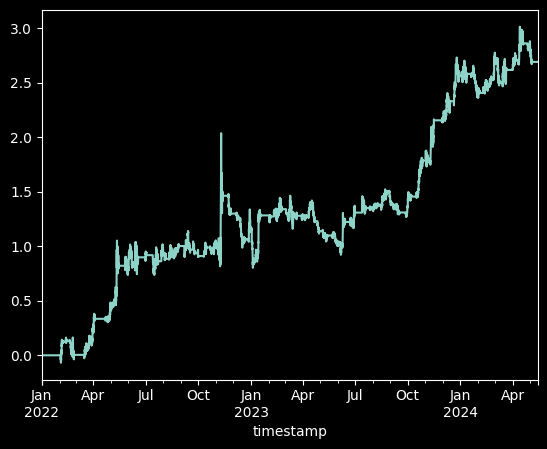

In [93]:
data['v_hawk'] = hawkes_process(data['norm_range'], 0.1)
data['sig'] = vol_signal(data['close'], data['v_hawk'], 168)

data['next_return'] = np.log(data['close']).diff().shift(-1)
data['signal_return'] = data['sig'] * data['next_return']
win_returns = data[data['signal_return'] > 0]['signal_return'].sum()
lose_returns = data[data['signal_return'] < 0]['signal_return'].abs().sum()
signal_pf = win_returns / lose_returns
plt.style.use('dark_background')
data['signal_return'].cumsum().plot()